In [1]:
import os, sys
sys.path.insert(0, '..')

In [2]:
import matplotlib.pyplot as plt
from spencer2017 import *
import jax.numpy as jnp
from functools import partial
from jax.scipy.special import logsumexp
%config InlineBackend.figure_format='retina'
plt.rcParams.update({'axes.linewidth'    : 0.4,
                     'ytick.major.width' : 0.4,
                     'ytick.minor.width' : 0.4,
                     'xtick.major.width' : 0.4,
                     'xtick.minor.width' : 0.4,
                     'xtick.major.size'  : 4,
                     'xtick.minor.size'  : 2,
                     'ytick.major.size'  : 4,
                     'ytick.minor.size'  : 2,
                     'xtick.minor.visible' : 'True',
                     'ytick.minor.visible' : 'True',
                     'xtick.labelsize': 8, 
                     'ytick.labelsize': 8,
                     'axes.labelsize' : 8,
                     'font.family': 'Serif',
                     'figure.figsize': (3.5, 3.33),
                     'figure.dpi' : 200,
                     'ytick.right': 'True',
                     'xtick.top'  : 'True',
                     'ytick.direction': 'in',
                     'xtick.direction': 'in',
                     'axes.spines.top': 'True',
                     'axes.grid': 'False',
                     'grid.linestyle': '--',
                     'grid.linewidth': 0.10
                    })
import seaborn as sns
sns.set_palette('deep')

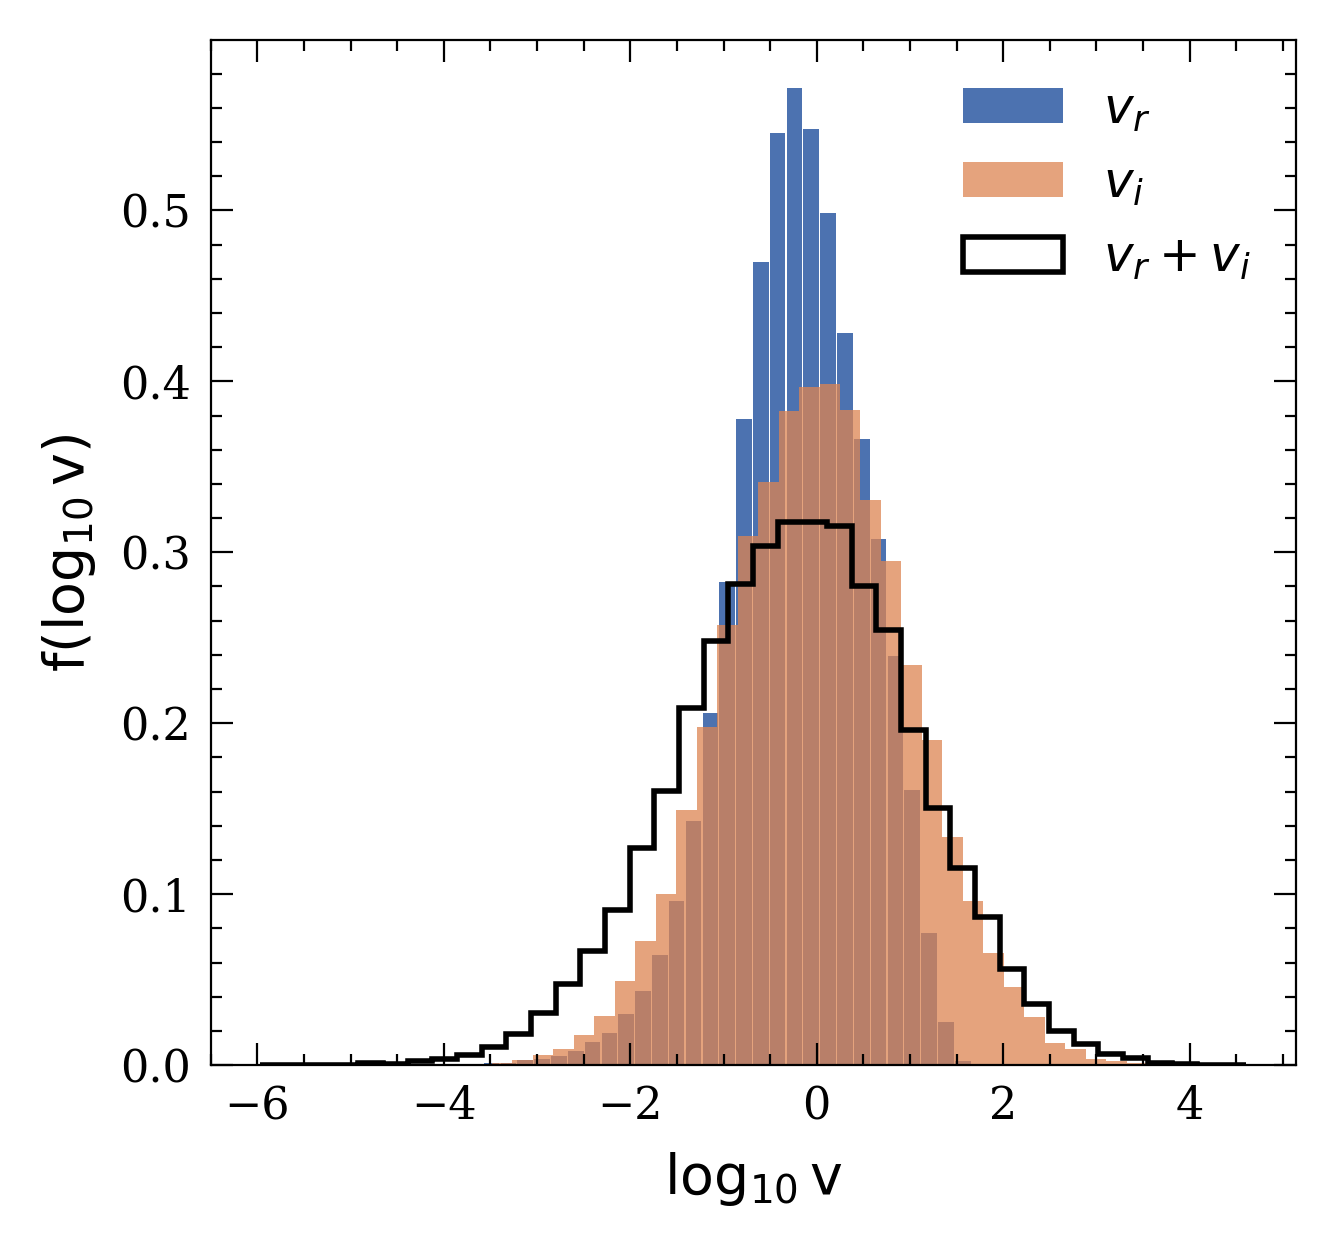

In [3]:
def main():
    v_loc   = 0
    v_scale = 1
    key = random.key(11)
    m = jnp.array([0.8]*40000)
    log_g = jnp.array([1]*40000)
    bin_frac = 1.0
    state = generate_orbit_state(key,bin_frac,m,log_g)
    plt.hist(jnp.log10(jnp.abs(state.velocities.v_r[state.binaries])), bins=40, density=True,
            histtype='bar', rwidth=0.930, label=r'$v_r$')
    d = random.normal(key=random.key(11),shape=(40000,))
    plt.hist(d, alpha=0.75, density=True,histtype='bar', 
             bins=40,rwidth=1,label=r'$v_i$')
    plt.hist(d + jnp.log10(jnp.abs(state.velocities.v_r[state.binaries])),
            histtype='step', density=True, color='k', bins=40,
            label=r'$v_r + v_i$')
    plt.ylabel(r'$\mathrm{f(\log_{10}v)}$', fontsize=10)
    plt.xlabel(r'$\log_{10}\mathrm{v}$', fontsize=10)
    plt.legend(fontsize=9, frameon=False)
    plt.savefig('../figs/vrdist.pdf', bbox_inches='tight')
    plt.show()
main()

In [4]:
def generate_grid(key, m, log_g, n_obs, dt_yrs):
    """ Grid of simulated data with 0 obs error """
    dt_day = 365.25 * dt_yrs
    m = jnp.array([m]*10000)
    log_g = jnp.array([log_g]*10000)
    bin_frac = 1.0
    state = generate_orbit_state(key,bin_frac,m,log_g,v_i_scale=0)
    masses_masked = state.m_1[state.binaries]
    body_fn = jax.jit(partial(step,dt_days=dt_day))
    true_binaries=state.binaries
    frac = []
    stacked_v_t = []
    for j in range(n_obs):
        key, _ = random.split(key)
        state = body_fn(key=key,masses_masked=masses_masked,state=state)
        v_t = state.velocities.v_t
        stacked_v_t.append(v_t)
    stacked_v_t = jnp.array(stacked_v_t).T
    
    return stacked_v_t

def generate_observations(key, m, log_g, n_obs, dt_yrs, sigma_obs, bin_frac=0.5):
    dt_day = 365.25 * dt_yrs
    m = jnp.array([m]*2000)
    log_g = jnp.array([log_g]*2000)
    state = generate_orbit_state(key,bin_frac,m,log_g,v_i_scale=sigma_obs)
    masses_masked = state.m_1[state.binaries]
    body_fn = jax.jit(partial(step,dt_days=dt_day))
    true_binaries=state.binaries
    stacked_v_t = []
    for j in range(n_obs):
        key, _ = random.split(key)
        state = body_fn(key=key,masses_masked=masses_masked,state=state)
        v_t = state.velocities.v_t
        stacked_v_t.append(v_t)
    stacked_v_t = jnp.array(stacked_v_t).T
    return stacked_v_t, true_binaries

def calculate_log_p_H0(observed_velocities, sigma):
    """Calculate log likelihood under H0 (single star) for each star."""
    n = observed_velocities.shape[1]
    sample_mean = jnp.mean(observed_velocities, axis=1)
    sample_var = jnp.var(observed_velocities, axis=1, ddof=1)
    term1 = - (n - 1)/2 * jnp.log(2 * jnp.pi)
    term2 = - (n - 1) * jnp.log(sigma)
    term3 = - 0.5 * jnp.log(n)
    term4 = - (n - 1) * sample_var / (2 * sigma**2)
    log_p_H0 = term1 + term2 + term3 + term4
    return log_p_H0

def calculate_log_p_H1(observed_velocities, true_binary_sequences, sigma):
    """Log likelihood under H1 (binary star)."""
    M = true_binary_sequences.shape[0]
    differences = observed_velocities[:, jnp.newaxis, :] - true_binary_sequences[jnp.newaxis, :, :]
    sum_sq = jnp.sum((differences / sigma)**2, axis=2)  # Shape: (2000, M)
    log_likelihoods = -0.5 * sum_sq - observed_velocities.shape[1] * jnp.log(sigma) - 0.5 * observed_velocities.shape[1] * jnp.log(2 * jnp.pi)
    log_p_H1 = logsumexp(log_likelihoods, axis=1) - jnp.log(M)
    return log_p_H1

In [5]:
import pandas as pd
import itertools
import jax
from jax import random
import jax.numpy as jnp
from functools import partial

# TODO: dt_yrs -> total_obs_time, then dt = total_obs_time/n_obs
param_grid = {
    "m": [0.8],
    "log_g": [1.5, 3.0, 4.0],
    "n_obs": [3, 5, 10, 20, 30],
    "dt_yrs": [0.5, 1.0, 3.0, 5.0],
    "sigma_obs": [0.1, 0.5, 1.0],
    "threshold": [0.9997]
}

param_combinations = list(itertools.product(*param_grid.values()))
param_names = list(param_grid.keys())

def run_experiment(params, key):
    """Run one experiment for a given parameter set."""
    m, log_g, n_obs, dt_yrs, sigma_obs, threshold = params
    n_obs = int(n_obs) 
    key, grid_key, obs_key = random.split(key, 3)
    
    model_grid = generate_grid(grid_key, m, log_g, n_obs, dt_yrs)
    obs, true_binaries = generate_observations(obs_key, m, log_g, n_obs, dt_yrs, sigma_obs)
    
    log_p_H0 = calculate_log_p_H0(obs, sigma_obs)
    log_p_H1 = calculate_log_p_H1(obs, model_grid, sigma_obs)
   
    log_odds = log_p_H1 - log_p_H0
    posterior_prob_H1 = 1 / (1 + jnp.exp(-log_odds))
    predicted = posterior_prob_H1 > threshold
    
    TP = jnp.sum((predicted == 1) & (true_binaries == 1))
    FP = jnp.sum((predicted == 1) & (true_binaries == 0))
    return dict(zip(param_names, params)) | {
        "TP": TP.item(), "FP": FP.item(), 'tot': true_binaries.sum().item()
    }

def main(key=random.PRNGKey(42)):
    # does not work with jax.vmap yet...
    keys = random.split(key, len(param_combinations))
    # batched_run = jax.vmap(run_experiment, in_axes=(0, 0))
    param_array = jnp.array(param_combinations)
    # results = batched_run(param_array, keys)
    results = []
    for i,p in enumerate(param_array):
        results.append(run_experiment(p, keys[i]))
    return results 

results = main()

In [6]:
df = pd.DataFrame(results)
df

,m,log_g,n_obs,dt_yrs,sigma_obs,threshold,TP,FP,tot
0,0.8,1.5,3.0,0.5,0.1,0.9997,329,0,1001
1,0.8,1.5,3.0,0.5,0.5,0.9997,238,0,1002
2,0.8,1.5,3.0,0.5,1.0,0.9997,151,0,981
3,0.8,1.5,3.0,1.0,0.1,0.9997,402,0,1002
4,0.8,1.5,3.0,1.0,0.5,0.9997,227,0,982
...,...,...,...,...,...,...,...,...,...
175,0.8,4.0,30.0,3.0,0.5,0.9997,626,0,1008
176,0.8,4.0,30.0,3.0,1.0,0.9997,487,0,1012
177,0.8,4.0,30.0,5.0,0.1,0.9997,831,0,1029
178,0.8,4.0,30.0,5.0,0.5,0.9997,682,0,1013


In [7]:
df = df.astype(float)
df.TP = df.TP/df.tot

really bad plotting code do not judge

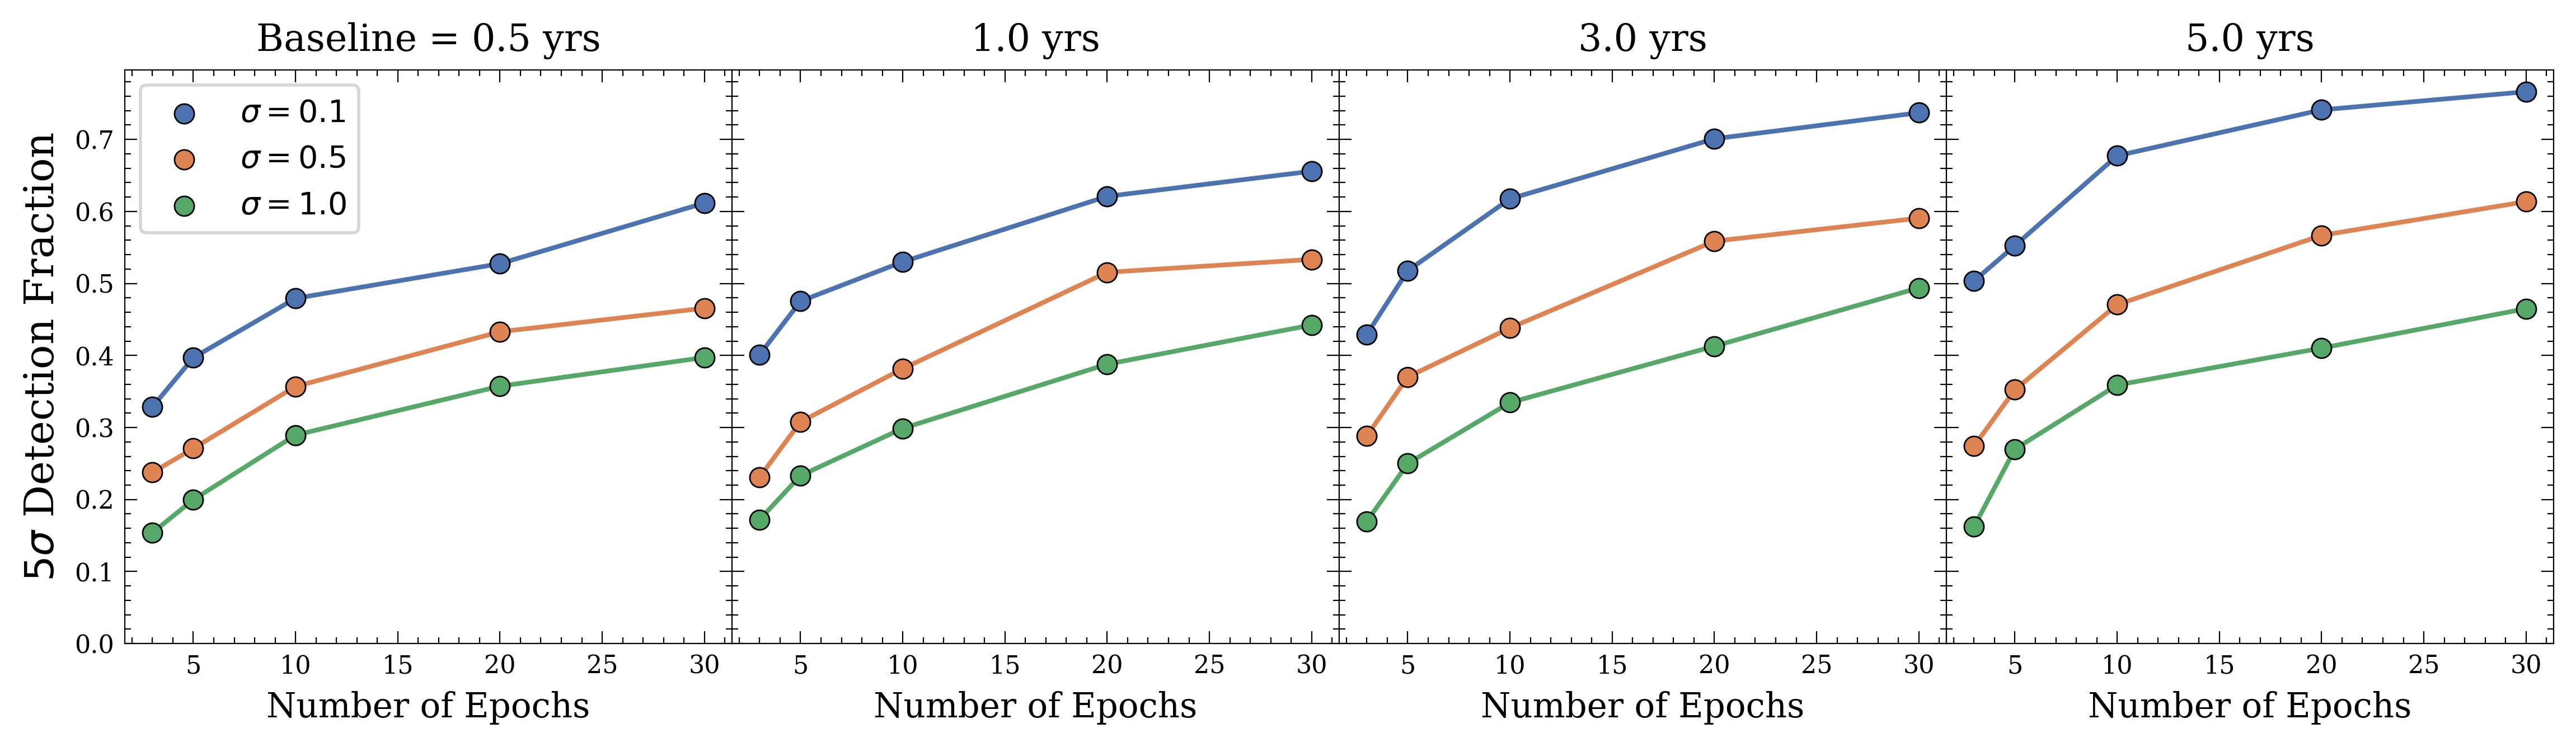

In [10]:
import seaborn as sns
param_grid = {
    "log_g": [1.5, 3.0, 4.0],
    "n_obs": [3, 5, 10, 30],
    "dt_yrs": [0.5, 1.0, 3.0, 5.0],
    "sigma_obs": [0.1, 0.5, 1.0],
}

fig, axs = plt.subplots(1,4, figsize=(4*3.5,3.33), sharey=True)
plt.subplots_adjust(wspace=0.0)

axs[0].scatter(df[(df.log_g==1.5) & (df.dt_yrs==0.5) & (df['sigma_obs']!=0.5) & (df['sigma_obs']!=1.0)].n_obs, 
            df[(df.log_g==1.5) & (df.dt_yrs==0.5) & (df['sigma_obs']!=0.5) & (df['sigma_obs']!=1.0)].TP,
            zorder=10, s=40, edgecolors='k', lw=0.5, label=r'$\sigma = 0.1$'
           )
axs[0].scatter(df[(df.log_g==1.5) & (df.dt_yrs==0.5) & (df.sigma_obs==0.5)].n_obs, 
               df[(df.log_g==1.5) & (df.dt_yrs==0.5) & (df.sigma_obs==0.5)].TP,
            zorder=10, s=40, edgecolors='k', lw=0.5, label=r'$\sigma = 0.5$'
           )
axs[0].scatter(df[(df.log_g==1.5) & (df.dt_yrs==0.5) & (df.sigma_obs==1.0)].n_obs, 
            df[(df.log_g==1.5) & (df.dt_yrs==0.5) & (df.sigma_obs==1.0)].TP,
            zorder=10, s=40, edgecolors='k', lw=0.5, label=r'$\sigma = 1.0$'
           )
axs[0].plot(df[(df.log_g==1.5) & (df.dt_yrs==0.5) & (df['sigma_obs']!=0.5) & (df['sigma_obs']!=1.0)].n_obs, 
            df[(df.log_g==1.5) & (df.dt_yrs==0.5) & (df['sigma_obs']!=0.5) & (df['sigma_obs']!=1.0)].TP,
           )
axs[0].plot(df[(df.log_g==1.5) & (df.dt_yrs==0.5) & (df.sigma_obs==0.5)].n_obs, 
            df[(df.log_g==1.5) & (df.dt_yrs==0.5) & (df.sigma_obs==0.5)].TP,
           )
axs[0].plot(df[(df.log_g==1.5) & (df.dt_yrs==0.5) & (df.sigma_obs==1.0)].n_obs, 
            df[(df.log_g==1.5) & (df.dt_yrs==0.5) & (df.sigma_obs==1.0)].TP,
           )
axs[1].scatter(df[(df.log_g==1.5) & (df.dt_yrs==1.0) & (df['sigma_obs']!=0.5) & (df['sigma_obs']!=1.0)].n_obs, 
               df[(df.log_g==1.5) & (df.dt_yrs==1.0) & (df['sigma_obs']!=0.5) & (df['sigma_obs']!=1.0)].TP,
            zorder=10, s=40, edgecolors='k', lw=0.5
           )
axs[1].scatter(df[(df.log_g==1.5) & (df.dt_yrs==1.0) & (df.sigma_obs==0.5)].n_obs, 
               df[(df.log_g==1.5) & (df.dt_yrs==1.0) & (df.sigma_obs==0.5)].TP,
            zorder=10, s=40, edgecolors='k', lw=0.5
           )
axs[1].scatter(df[(df.log_g==1.5) & (df.dt_yrs==1.0) & (df.sigma_obs==1.0)].n_obs, 
               df[(df.log_g==1.5) & (df.dt_yrs==1.0) & (df.sigma_obs==1.0)].TP,
            zorder=10, s=40, edgecolors='k', lw=0.5
           )
axs[1].plot(df[(df.log_g==1.5) & (df.dt_yrs==1.0) & (df['sigma_obs']!=0.5) & (df['sigma_obs']!=1.0)].n_obs, 
            df[(df.log_g==1.5) & (df.dt_yrs==1.0) & (df['sigma_obs']!=0.5) & (df['sigma_obs']!=1.0)].TP,
           )
axs[1].plot(df[(df.log_g==1.5) & (df.dt_yrs==1.0) & (df.sigma_obs==0.5)].n_obs, 
            df[(df.log_g==1.5) & (df.dt_yrs==1.0) & (df.sigma_obs==0.5)].TP,
           )
axs[1].plot(df[(df.log_g==1.5) & (df.dt_yrs==1.0) & (df.sigma_obs==1.0)].n_obs, 
            df[(df.log_g==1.5) & (df.dt_yrs==1.0) & (df.sigma_obs==1.0)].TP,
           )
axs[2].scatter(df[(df.log_g==1.5) & (df.dt_yrs==3.0) & (df['sigma_obs']!=0.5) & (df['sigma_obs']!=1.0)].n_obs, 
               df[(df.log_g==1.5) & (df.dt_yrs==3.0) & (df['sigma_obs']!=0.5) & (df['sigma_obs']!=1.0)].TP,
            zorder=10, s=40, edgecolors='k', lw=0.5
           )
axs[2].scatter(df[(df.log_g==1.5) & (df.dt_yrs==3.0) & (df.sigma_obs==0.5)].n_obs, 
               df[(df.log_g==1.5) & (df.dt_yrs==3.0) & (df.sigma_obs==0.5)].TP,
            zorder=10, s=40, edgecolors='k', lw=0.5
           )
axs[2].scatter(df[(df.log_g==1.5) & (df.dt_yrs==3.0) & (df.sigma_obs==1.0)].n_obs, 
               df[(df.log_g==1.5) & (df.dt_yrs==3.0) & (df.sigma_obs==1.0)].TP,
            zorder=10, s=40, edgecolors='k', lw=0.5
           )
axs[2].plot(df[(df.log_g==1.5) & (df.dt_yrs==3.0) & (df['sigma_obs']!=0.5) & (df['sigma_obs']!=1.0)].n_obs, 
            df[(df.log_g==1.5) & (df.dt_yrs==3.0) & (df['sigma_obs']!=0.5) & (df['sigma_obs']!=1.0)].TP,
           )
axs[2].plot(df[(df.log_g==1.5) & (df.dt_yrs==3.0) & (df.sigma_obs==0.5)].n_obs, 
            df[(df.log_g==1.5) & (df.dt_yrs==3.0) & (df.sigma_obs==0.5)].TP,
           )
axs[2].plot(df[(df.log_g==1.5) & (df.dt_yrs==3.0) & (df.sigma_obs==1.0)].n_obs, 
            df[(df.log_g==1.5) & (df.dt_yrs==3.0) & (df.sigma_obs==1.0)].TP,
           )
axs[3].scatter(df[(df.log_g==1.5) & (df.dt_yrs==5.0) & (df['sigma_obs']!=0.5) & (df['sigma_obs']!=1.0)].n_obs, 
               df[(df.log_g==1.5) & (df.dt_yrs==5.0) & (df['sigma_obs']!=0.5) & (df['sigma_obs']!=1.0)].TP,
            zorder=10, s=40, edgecolors='k', lw=0.5
           )
axs[3].scatter(df[(df.log_g==1.5) & (df.dt_yrs==5.0) & (df.sigma_obs==0.5)].n_obs, 
               df[(df.log_g==1.5) & (df.dt_yrs==5.0) & (df.sigma_obs==0.5)].TP,
            zorder=10, s=40, edgecolors='k', lw=0.5
           )
axs[3].scatter(df[(df.log_g==1.5) & (df.dt_yrs==5.0) & (df.sigma_obs==1.0)].n_obs, 
               df[(df.log_g==1.5) & (df.dt_yrs==5.0) & (df.sigma_obs==1.0)].TP,
            zorder=10, s=40, edgecolors='k', lw=0.5
           )
axs[3].plot(df[(df.log_g==1.5) & (df.dt_yrs==5.0) & (df['sigma_obs']!=0.5) & (df['sigma_obs']!=1.0)].n_obs, 
            df[(df.log_g==1.5) & (df.dt_yrs==5.0) & (df['sigma_obs']!=0.5) & (df['sigma_obs']!=1.0)].TP,
           )
axs[3].plot(df[(df.log_g==1.5) & (df.dt_yrs==5.0) & (df.sigma_obs==0.5)].n_obs, 
            df[(df.log_g==1.5) & (df.dt_yrs==5.0) & (df.sigma_obs==0.5)].TP,
           )
axs[3].plot(df[(df.log_g==1.5) & (df.dt_yrs==5.0) & (df.sigma_obs==1.0)].n_obs, 
            df[(df.log_g==1.5) & (df.dt_yrs==5.0) & (df.sigma_obs==1.0)].TP,
           )
axs[0].legend()
axs[0].set_ylim(0)
axs[0].set_xlabel('Number of Epochs', fontsize=11)
axs[1].set_xlabel('Number of Epochs', fontsize=11)
axs[2].set_xlabel('Number of Epochs', fontsize=11)
axs[3].set_xlabel('Number of Epochs', fontsize=11)
axs[0].set_ylabel(r'$5\sigma$ Detection Fraction', fontsize=13)
axs[0].set_title('Baseline = 0.5 yrs')
axs[1].set_title('1.0 yrs')
axs[2].set_title('3.0 yrs')
axs[3].set_title('5.0 yrs')
ymax = max(df.TP)
axs[0].axhline(ymax,xmin=0,xmax=30, ls='--', c='k')
axs[1].axhline(ymax,xmin=0,xmax=30, ls='--', c='k')
axs[2].axhline(ymax,xmin=0,xmax=30, ls='--', c='k')
axs[3].axhline(ymax,xmin=0,xmax=30, ls='--', c='k')
plt.savefig('../figs/detect_fracs.pdf', bbox_inches='tight')
plt.show()